<a href="https://colab.research.google.com/github/sana-kabbani/PD_Classification/blob/main/image_audio_late.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import os
import pickle
import numpy as np
import argparse
from random import random

from torch import optim
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.nn import functional as F

from sklearn.utils import shuffle

import numpy as np
import random

import torch
import torch.nn as nn
from torch.autograd import Function
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [ ]:
import pandas as pd
import pickle

# Replace 'your_file.pkl' with the path to your pickle file
file_path = '/content/drive/MyDrive/PD_Data/PD_t.pkl'

# Open the pickle file in binary read mode
with open(file_path, 'rb') as file:
    df = pickle.load(file)
df = df.reset_index(drop=True)

# df_label_A = df[df['label'] == 0]
# df_label_B = df[df['label'] == 1]

# # Sample one row from each subset
# sample_A = df_label_A.sample(50, random_state=42)
# sample_B = df_label_B.sample(50, random_state=42)

# # Combine the sampled rows into a single DataFrame
# sampled_df = pd.concat([sample_A, sample_B])
# df = sampled_df.reset_index(drop=True)

X = df[['img_path', 'mfcc']]
y = df['label']


In [ ]:
df

,img_path,label,audio_path,mfcc,transcription
0,/content/drive/MyDrive/PD_Data/imgs/parkinson_...,1,/content/drive/MyDrive/PD_Data/audio/parkinson...,"[-310.08588, 144.27586, 22.283592, 24.739786, ...",in everyday life I have to think about everyth...
1,/content/drive/MyDrive/PD_Data/imgs/parkinson_...,1,/content/drive/MyDrive/PD_Data/audio/parkinson...,"[-305.36154, 151.59064, 17.337847, 15.328877, ...",this or that because I will be very tired so very
2,/content/drive/MyDrive/PD_Data/imgs/parkinson_...,1,/content/drive/MyDrive/PD_Data/audio/parkinson...,"[-298.43488, 143.4179, 8.849281, 20.252604, -1...",hi I'm Nikita and 24 years old and I have Park...
3,/content/drive/MyDrive/PD_Data/imgs/parkinson_...,1,/content/drive/MyDrive/PD_Data/audio/parkinson...,"[-313.74124, 132.58064, 22.564722, 19.340528, ...",I was diagnosed at 20 years old I was
4,/content/drive/MyDrive/PD_Data/imgs/parkinson_...,1,/content/drive/MyDrive/PD_Data/audio/parkinson...,"[-315.90396, 153.26161, 7.4231963, 23.949207, ...",turn on the ski holiday with my mother in Aust...
...,...,...,...,...,...
2554,/content/drive/MyDrive/PD_Data/imgs/non_parkin...,0,/content/drive/MyDrive/PD_Data/audio/non_parki...,"[-361.9486, 88.160286, 8.488315, 40.21863, 10....",give way of thinking as well at the same time ...
2555,/content/drive/MyDrive/PD_Data/imgs/non_parkin...,0,/content/drive/MyDrive/PD_Data/audio/non_parki...,"[-366.68866, 62.199337, 8.455774, 45.813965, 1...",it really does have its pros and cons but if y...
2556,/content/drive/MyDrive/PD_Data/imgs/non_parkin...,0,/content/drive/MyDrive/PD_Data/audio/non_parki...,"[-339.61575, 77.2035, 0.5710298, 36.623737, 21...",so I kind of wanted to bring out the idea
2557,/content/drive/MyDrive/PD_Data/imgs/non_parkin...,0,/content/drive/MyDrive/PD_Data/audio/non_parki...,"[-429.5933, 64.712296, 13.766346, 45.083443, 2...",like you know you could be different and you c...


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
from PIL import Image, UnidentifiedImageError
import os

transform = transforms.Compose([
    transforms.Resize((185, 185)),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(10),      # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.ToTensor()
])


class CustomImageAudioDataset(Dataset):
    def __init__(self, img_files, audio_data, targets, transform=None):
        """
        Args:
            img_files (list): List of image file paths.
            audio_data (numpy array): Array of audio data.
            targets (numpy array): Array of target labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_files = img_files
        self.audio_data = audio_data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_files[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, UnidentifiedImageError):
            # If the image is not found, create a placeholder image (black image)
            image = Image.new('RGB', (185, 185), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        audio = self.audio_data[idx]
        audio = torch.tensor(audio, dtype=torch.float32)

        target = torch.tensor(self.targets[idx], dtype=torch.long)

        return audio, image, target


In [ ]:
def createLoaders(full_train_dataset, batch_size = 4):
# Split dataset
    global dataset_sizes
    dataset_size = len(full_train_dataset)
    val_size = int(0.2*dataset_size)
    train_size = dataset_size-val_size
    dataset_sizes = {'train':train_size, 'val':val_size}

    train_dataset, val_dataset = random_split(
            full_train_dataset,
            [train_size, val_size],
            generator=torch.Generator().manual_seed(42)
    )

    # Create dataloaders
    trainloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True
    )
    valloader   = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=True
    )

    return trainloader, valloader

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class MMF_Model(nn.Module):
    def __init__(self, num_layers_mfccs=3):
        super(MMF_Model, self).__init__()

        # LSTM for MFCCs
        self.num_layers_mfccs = num_layers_mfccs
        self.lstm_mfccs = nn.LSTM(input_size=1, hidden_size=16, num_layers=self.num_layers_mfccs, bidirectional=True, batch_first=True)
        self.fc_mfccs = nn.Linear(32, 128)  # 32 because 16 * 2 (bidirectional)

        # CNN for images
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc_image = nn.Linear(128 * 23 * 23, 256)  # Adjust the input size according to the output size of the last CNN layer

        # Fusion
        self.fc_final = nn.Linear(128 + 256, 1)  # Fusion of MFCCs and images
        self.sigmoid = nn.Sigmoid()

    def forward(self, mfccs, images, lengths):
        # Process MFCCs
        mfccs = mfccs.unsqueeze(-1)  # Add a feature dimension
        packed_mfccs = pack_padded_sequence(mfccs, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm_mfccs(packed_mfccs)
        output_mfccs, _ = pad_packed_sequence(packed_output, batch_first=True)
        batch_size = output_mfccs.size(0)
        last_output_mfccs = output_mfccs[torch.arange(batch_size), lengths - 1, :]
        mfccs_features = self.fc_mfccs(last_output_mfccs)

        # Process Images with CNN
        x = self.pool(F.relu(self.conv1(images)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        image_features = F.relu(self.fc_image(x))

        # Fusion
        fused_features = torch.cat((mfccs_features, image_features), dim=1)
        final_output = self.fc_final(fused_features)
        final_output = self.sigmoid(final_output)

        return final_output

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MMF_Model(num_layers_mfccs=3).to(device)


In [ ]:
from torch.utils.data import random_split
full_train_dataset = CustomImageAudioDataset( X["img_path"],X["mfcc"],y,transform)
trainloader, valloader = createLoaders(full_train_dataset)
dataloaders = {'train': trainloader, 'val':valloader}


In [ ]:
from time import perf_counter
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def eval_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    start_time = perf_counter()
    with torch.no_grad():
        for mfccs, images, labels in loader:
            # mfccs, images, labels = mfccs.cuda(), images.cuda(), labels.cuda()

            lengths = torch.LongTensor([mfccs.size(1)] * mfccs.size(0)).cpu()  # Move lengths to CPU

            outputs = model(mfccs, images, lengths)
            outputs = outputs.squeeze()  # Remove the last dimension
            loss = criterion(outputs, labels.float())  # Convert labels to float for BCELoss
            total_loss += loss.item()
            preds = (outputs >= 0.5).long()
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    end_time = perf_counter()
    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    classification_rep = classification_report(all_labels, all_preds, zero_division=1)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    specificity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    return avg_loss, accuracy, classification_rep, conf_matrix, sensitivity, specificity, end_time - start_time

# Initialize model, loss function, and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # Add weight decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs

train_losses = []
val_losses = []
accuracies = []
sensitivities = []
specificities = []
train_times = []
test_times = []

for epoch in range(15):
    model.train()
    total_loss = 0
    start_time = perf_counter()
    for mfccs, images, labels in trainloader:
        # mfccs, images, labels = mfccs.cuda(), images.cuda(), labels.cuda()
        optimizer.zero_grad()
        lengths = torch.LongTensor([mfccs.size(1)] * mfccs.size(0)).cpu()  # Move lengths to CPU

        outputs = model(mfccs, images, lengths)
        outputs = outputs.squeeze()  # Remove the last dimension
        loss = criterion(outputs, labels.float())  # Convert labels to float for BCELoss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    end_time = perf_counter()
    train_time = end_time - start_time
    train_times.append(train_time)
    scheduler.step()  # Step the learning rate scheduler

    avg_train_loss = total_loss / len(trainloader)
    val_loss, val_accuracy, classification_rep, conf_matrix, sensitivity, specificity, test_time = eval_model(model, valloader, criterion)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    accuracies.append(val_accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    test_times.append(test_time)

    print(f"Epoch {epoch+1}/{15}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print("Validation metrics:")
    print(classification_rep)
    print("Confusion matrix:")
    print(conf_matrix)
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Train time: {train_time:.2f} seconds")
    print(f"Test time: {test_time:.2f} seconds")


Epoch 1/15, Train Loss: 0.4232, Val Loss: 0.3141, Val Accuracy: 0.8552
Validation metrics:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       255
           1       0.89      0.81      0.85       256

    accuracy                           0.86       511
   macro avg       0.86      0.86      0.85       511
weighted avg       0.86      0.86      0.85       511

Confusion matrix:
[[230  25]
 [ 49 207]]
Sensitivity: 0.9020
Specificity: 0.8086
Train time: 750.38 seconds
Test time: 185.87 seconds
Epoch 2/15, Train Loss: 0.2181, Val Loss: 0.1644, Val Accuracy: 0.9374
Validation metrics:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       255
           1       0.91      0.98      0.94       256

    accuracy                           0.94       511
   macro avg       0.94      0.94      0.94       511
weighted avg       0.94      0.94      0.94       511

Confusion matrix:
[[229  26]
 

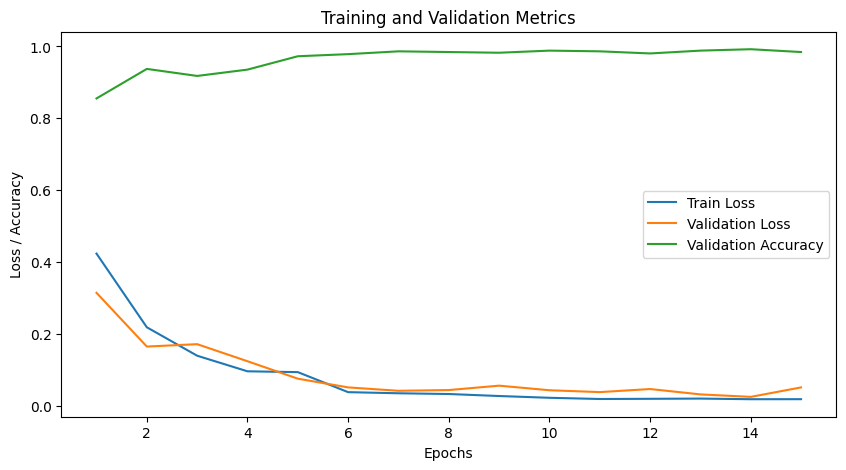

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 16), train_losses, label='Train Loss')
plt.plot(range(1, 16), val_losses, label='Validation Loss')
plt.plot(range(1, 16), accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Metrics')
plt.legend()
plt.show()

In [ ]:
# Path to save the model's state dictionary
save_path = '/content/drive/MyDrive/PD_Data/_trained_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/PD_Data/_trained_model.pth


In [ ]:
from google.colab import drive
drive.mount('/content/drive')